# Ordinal Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

In [2]:
# data from Kruschke (Ch. 23)

df = pd.read_csv('OrdinalProbitData-LinReg-2.csv', dtype={'Y':'category'})
df
# X - income
# Y - happiness level

,X,Y
0,1.386389,1
1,1.223879,1
2,1.454505,5
3,1.112068,5
4,1.222715,1
...,...,...
195,1.051088,1
196,1.405100,4
197,1.176598,1
198,1.605308,4


In [3]:
print(df.Y.unique()) 
n_classes = len(df.Y.unique())
print(n_classes)

['1', '5', '4', '6', '2', '7', '3']
Categories (7, object): ['1', '5', '4', '6', '2', '7', '3']
7


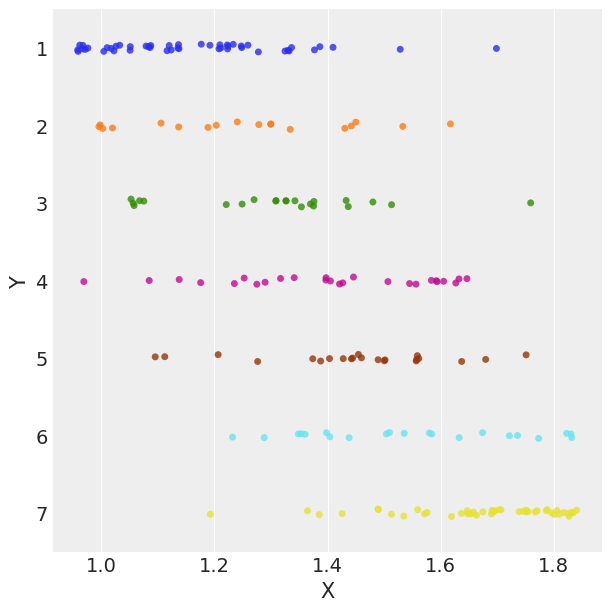

In [4]:
plt.figure(figsize=(6, 6))
sns.stripplot(x="X", y="Y", data=df, alpha=0.8, jitter=0.05);

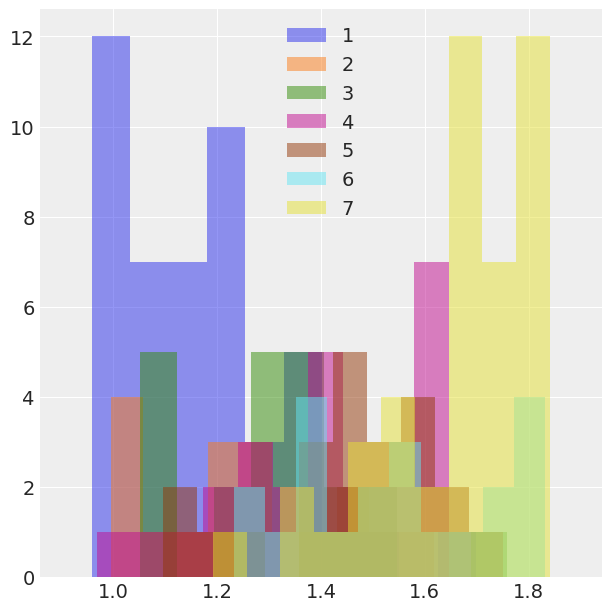

In [5]:
plt.figure(figsize=(6, 6))
plt.xlim(df.X.min() - 0.1, df.X.max() + 0.1)
for k in range(1, n_classes+1):
    plt.hist(df.X[df.Y==str(k)], 10, alpha=0.5, label=k)
plt.legend();

In [6]:
# normalize predictor
x_mean = df.X.mean()
x_scale = df.X.std()
print(x_mean, x_scale)
X = (df.X - x_mean )/x_scale
t = df.Y.astype(int)

1.4024405261345665 0.25037540990534307


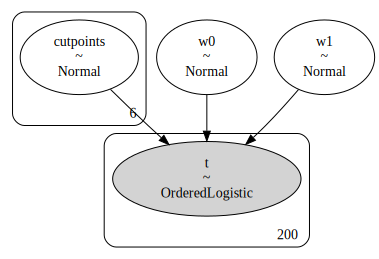

In [7]:
# Ordered logistic regression

with pm.Model() as model:
    cutpoints = pm.Normal("cutpoints", mu=np.arange(1, n_classes) + 0.5, sigma=1, 
                          shape=n_classes-1,
                          transform=pm.distributions.transforms.ordered) # ordered!
    w0 = pm.Normal('w0', mu=4, sigma=10)
    w1 = pm.Normal('w1', mu=0, sigma=10)
    eta = w0 + w1 * X  
    outputs = pm.OrderedLogistic("t", cutpoints=cutpoints, eta=eta, observed=t-1)

pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample(draws=2000, tune=1000, chains=2, cores=2,
                     return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w1, w0, cutpoints]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


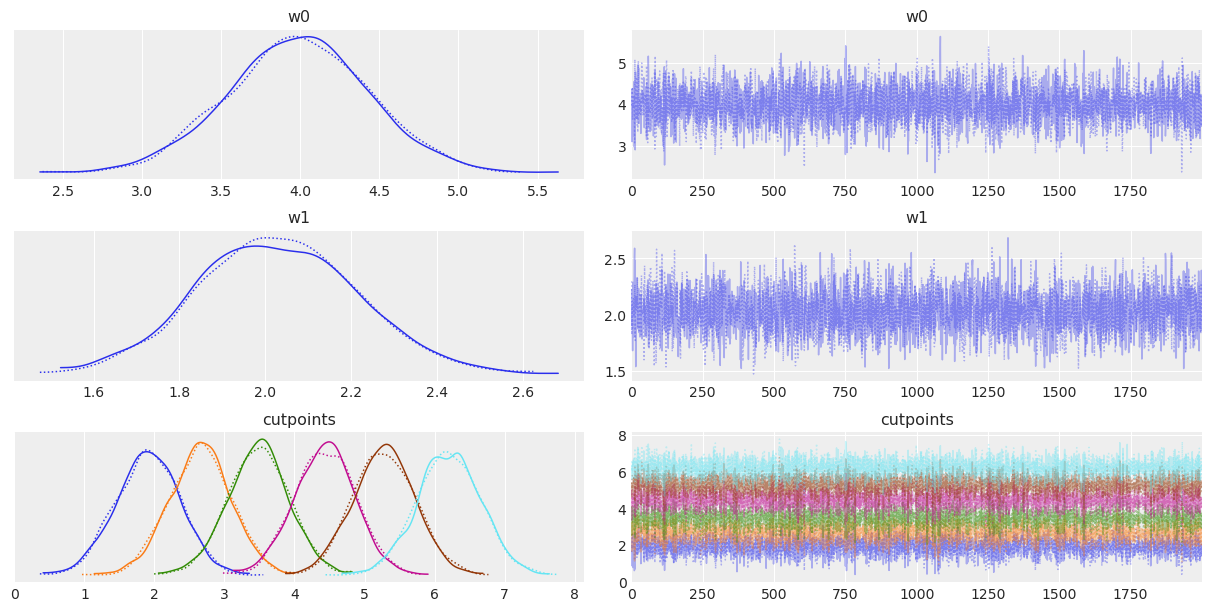

In [9]:
az.plot_trace(trace);

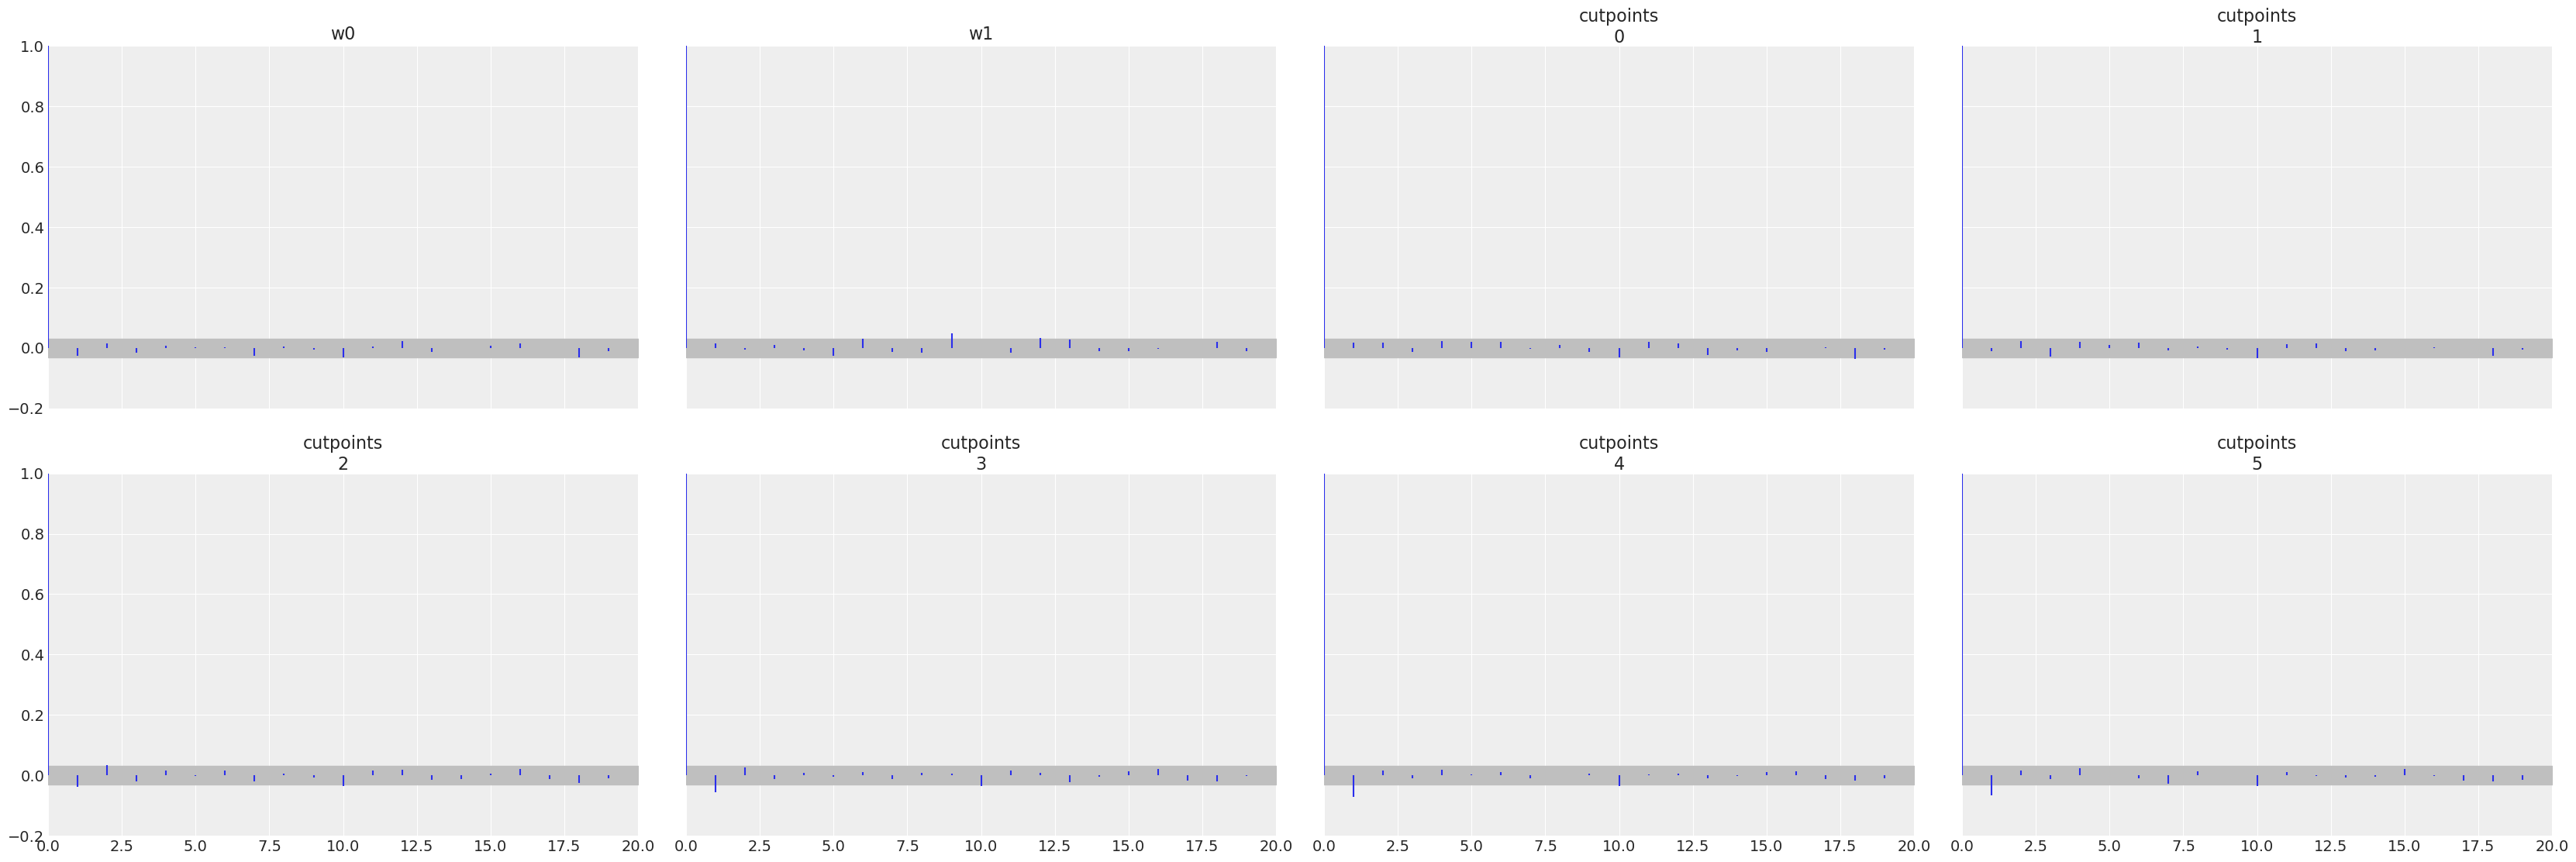

In [10]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,3.984,0.441,3.150,4.809,0.007,0.005,4160.0,2573.0,1.0
w1,2.028,0.184,1.662,2.356,0.003,0.002,3881.0,2813.0,1.0
cutpoints[0],1.908,0.455,1.065,2.748,0.007,0.005,3747.0,2375.0,1.0
cutpoints[1],2.652,0.440,1.878,3.525,0.007,0.005,4033.0,2637.0,1.0
cutpoints[2],3.485,0.438,2.695,4.346,0.007,0.005,4080.0,2707.0,1.0
cutpoints[3],4.434,0.435,3.622,5.249,0.007,0.005,4305.0,3028.0,1.0
cutpoints[4],5.278,0.443,4.446,6.103,0.007,0.005,4509.0,2993.0,1.0
cutpoints[5],6.205,0.455,5.353,7.046,0.007,0.005,4569.0,2741.0,1.0


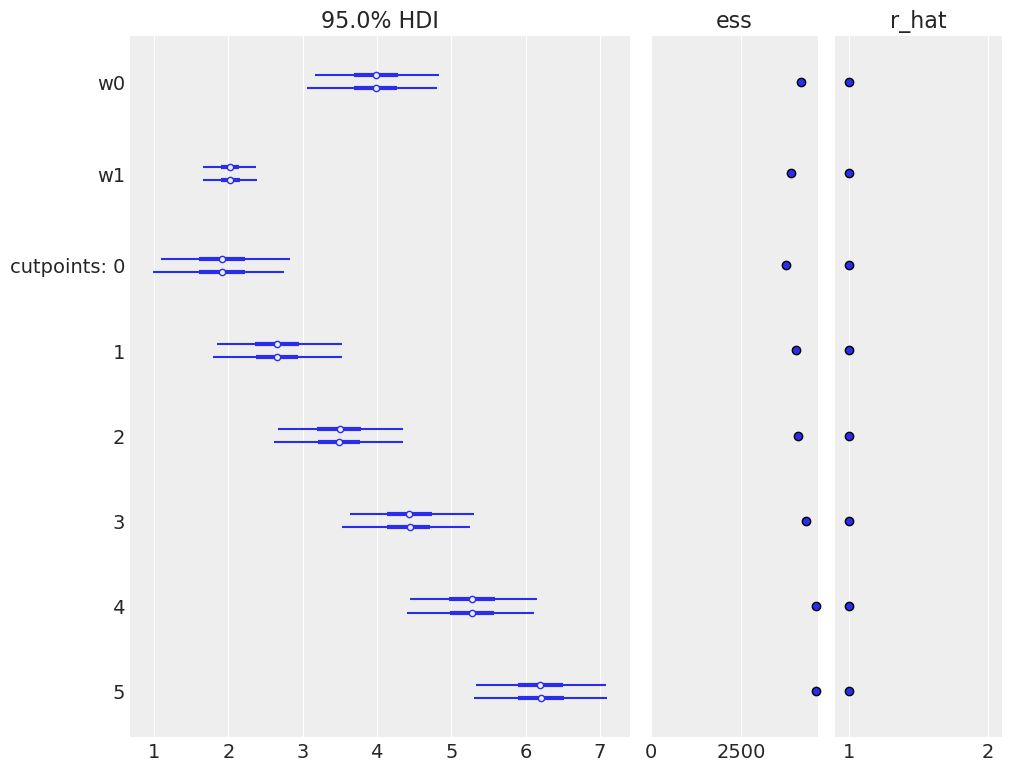

In [12]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True);

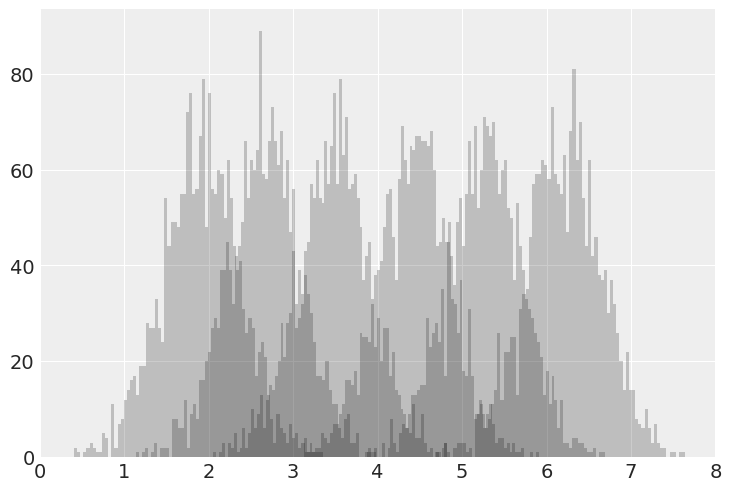

In [13]:
plt.xlim(0, 8)
for k in range(n_classes-1):
    plt.hist(trace.posterior['cutpoints'][0,:,k], 80, alpha=0.2, color='k');

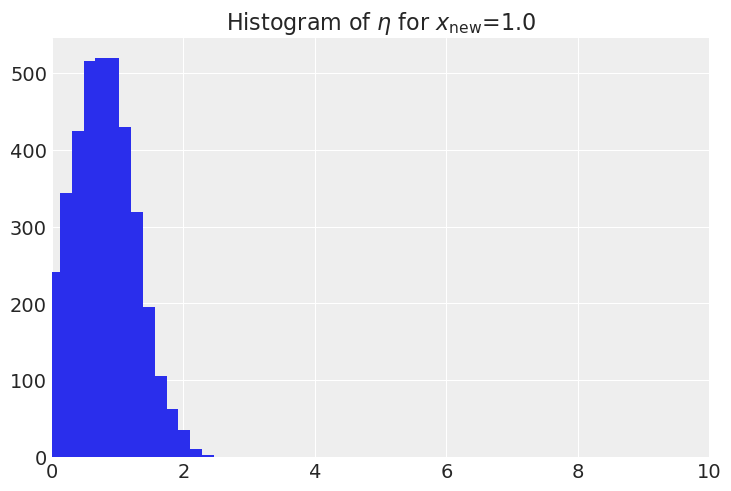

In [14]:
# prediction for new data
x_new = 1.0
plt.title('Histogram of $\eta$ for $x_\mathrm{new}$=' + str(x_new))
plt.xlim(0, 10)

x_new = (x_new - x_mean ) / x_scale
eta_new = trace.posterior['w0'].values.flatten() \
            + x_new * trace.posterior['w1'].values.flatten()
plt.hist(eta_new, bins = 20);

In [15]:
# calc probabilities for each class
cutpoints = trace.posterior['cutpoints'].values.reshape([-1, 6])
cutpoints = np.concatenate([np.full(shape=(cutpoints.shape[0], 1), fill_value=-np.inf),
                           cutpoints,
                           np.full(shape=(cutpoints.shape[0], 1), fill_value=+np.inf)
                           ], axis = -1)
probs = np.empty((eta_new.shape[0], n_classes), dtype=np.float32)
l = stats.logistic()
for k in range(n_classes):
    probs[:,k] = l.cdf(cutpoints[:,k+1]-eta_new) - l.cdf(cutpoints[:,k]-eta_new)
    
print(probs.shape)

(4000, 7)


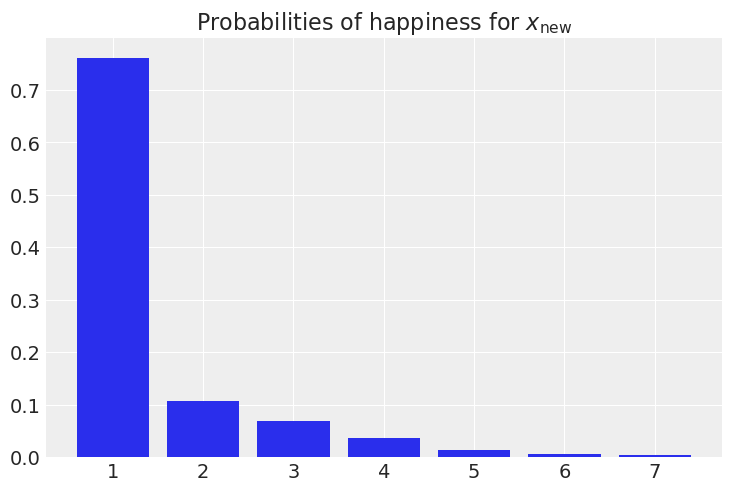

In [16]:
mean_probs = probs.mean(axis=0)
mean_probs
plt.title('Probabilities of happiness for $x_\mathrm{new}$')

plt.bar(range(1,n_classes+1), mean_probs);